# GRAIN CLASSIFICATION
This Jupyter notebook illustrates methods for classifying grains using different models or data representations.

### Imports
First of all, make sure all these libraries are installed and can be imported. The python version used is 3.10.13, haven't checked out yet if works for previous versions.

In [ ]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import ToTensor

from tqdm.notebook import tnrange, tqdm
from scipy.signal import convolve
from tabulate import tabulate

### CUDA acceleration

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

### NN Architecture
The neural network architecture consists of six hidden dense layers of width 512, one flatten input layer and a dense output layer to classify. Dropout layers have been added if needed but the default probability is set to 0. ReLu is the activation function between dense layers.

In [ ]:
class GrainClassifier(nn.Module):
    def __init__(self, input_size, output_size, layer_width=512, p_dropout=0.0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(layer_width, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(layer_width, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(layer_width, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(layer_width, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(layer_width, layer_width, dtype=torch.double),
            nn.ReLU(),
            nn.Dropout(p=p_dropout)
        )
        self.classification_layer = nn.Linear(layer_width, output_size, dtype=torch.double)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.classification_layer(x)
        return x

### Custom Dataset
Here a custom dataset is defined to load data from a partition of a class folder, i.e. given a dataset folder such as `Landraces` experiment and a partition such as `validation`, this dataset imports the validation folder for each label of Landraces experiment.

In [ ]:
class CustomDatasetFromFold(Dataset):
    def __init__(self, data_dir, fold):
        self.data_dir = data_dir
        # Listing classes
        self.classes = os.listdir(data_dir)
        self.classes.sort()
        self.data = []
        self.labels = []
        
        # dataset/class/fold
        # For every directory matching "fold"
        for class_index, class_path in enumerate(self.classes):
            in_class_paths = os.listdir(data_dir + "/" + class_path + "/" + fold)
            in_class_paths.sort()
            # For every file in the class directory
            for path in in_class_paths:
                pkl_path = data_dir + "/" + class_path + "/" + fold + "/" + path
                with open(pkl_path, 'rb') as pkl_file:
                    pkl_object = pickle.load(pkl_file)
                self.data.append(pkl_object)
                self.labels.append(class_index)

        self.data = torch.tensor(self.data)
        self.labels = torch.tensor(self.labels)
        #print(f"Dataset imported successfully! Classes: {len(self.classes)}, Samples: {self.data.shape[0]}, Sample length: {self.data.shape[1]}.")
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [ ]:
def train_one_epoch(model, dataloader):
    """
    Trains the model one epoch using data from dataloader.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        dataloader (DataLoader): The data loader providing batches of training data.

    Returns:
        running_loss(float): The total loss accumulated during training.
    """
    # Train mode
    model.train()

    running_loss = 0.0
    
    # Iterate over batches of data
    for inputs, labels in dataloader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_fn(outputs, labels)
        
        # Backward pass
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
    return running_loss

def validate_model(model, train_loader, validation_loader):
    """
    Evaluates the model using data from train and validation dataloaders.

    Parameters:
        model (nn.Module): The neural network model to be evaluated.
        train_loader (DataLoader): The data loader providing batches of training data.
        validation_loader (DataLoader): The data loader providing batches of validation data.

    Returns:
        train_accuracy (float): The accuracy of the model on the training set.
        val_accuracy (float): The accuracy of the model on the validation set.
        val_loss (float): The average loss on the validation set.
    """
    # Variables to accumulate
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        # Training accuracy
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs.data, 1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        # Validation accuracy + loss
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)

    # Accuracies
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total
    
    # Train mode
    model.train()
    return train_accuracy, val_accuracy, val_loss

def log_file_begin(log_path):
    """
    Begins a log file writing its header.

    Parameters:
        log_path (str): Path of the log file.
    """
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    with open(log_path, 'w') as file:
        file.write("Epoch,train_loss,train_accuracy,validation_loss,validation_accuracy\n")

def log_file_epoch(log_path, epoch, train_loss, train_accuracy, validation_loss, validation_accuracy):
    """
    Logs information of a training epoch.

    Parameters:
        log_path (str): Path of the log file.
        epoch (int)
        train_loss (float)
        train_accuracy (float)
        validation_loss (float)
        validation_accuracy (float)
    """
    with open(log_path, 'a') as file:
        file.write(f"{epoch},{train_loss},{train_accuracy},{validation_loss},{validation_accuracy}\n")

def log_file_parameters(log_path, best_accuracy, best_epoch, batch_size, train_size, validation_size, learning_rate, momentum):
    """
    Logs training parameters of a model.

    Parameters:
        log_path (str): Path of the log file.
        best_accuracy (float)
        best_epoch (int)
        batch_size (int)
        train_size (float)
        validation_size (float)
        learning_rate (float)
        momentum (float)
    """
    with open(log_path, 'a') as file:
        file.write(f"\n\nBest Accuracy: {best_accuracy} in epoch {best_epoch}\n")
        file.write("\nParameters:\n")
        file.write(f"- Batch size = {batch_size}\n")
        file.write(f"- Train size = {train_size}\n")
        file.write(f"- Validation size = {validation_size}\n")
        file.write(f"- Learning rate = {learning_rate}\n")
        file.write(f"- Momentum = {momentum}\n")

def get_unique_filepath(file_path):
    """
    Given a path to save a file, checks if exists and if so changes the identifier until it is unique.

    Parameters:
        file_path (str): Path to be unique.

    Returns:
        identifier (int): Unique identifier.
    """
    identifier = 1
    # If it exists, add a number to differentiate it
    file_name, file_extension = os.path.splitext(file_path)
    while True:
        new_file_path = f"{file_name}_{identifier}{file_extension}"
        if not os.path.exists(new_file_path):
            return identifier
        identifier += 1

def train_model(model, n_epochs, train_loader, validation_loader, model_save_path, log_path, terminal_printing=False, progress_bar=False):
    """
    Trains a model and logs every epoch.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        n_epochs (int): Number of epochs to train.
        train_loader (DataLoader): The data loader providing batches of training data.
        validation_loader (DataLoader): The data loader providing batches of validation data.
        model_save_path (str): Path to save the model.
        log_path (str): Path to log epochs.
        terminal_printing (bool | optional): Enables prints of logs also in terminal. Default is False.
        progress_bar (bool | optional): Displays a progress bar. Default is False.
    """
    # Begin log file
    log_file_begin(log_path)

    # For saving performance
    best_accuracy = 0
    best_epoch = 0
    accuracies = []
    
    # Loop length and progress bar
    epochs = range(n_epochs)
    if progress_bar:
        epochs = tqdm(epochs, dynamic_ncols=True)
    
    # Training loop
    for epoch in epochs:
        # Train model
        train_loss = train_one_epoch(model, train_loader)
        # Validate model
        train_accuracy, val_accuracy, validation_loss = validate_model(model, train_loader, validation_loader)
        if best_accuracy < val_accuracy:
            # Saving best epoch and accuracy
            best_accuracy = val_accuracy
            best_epoch = epoch
            # Print in terminal
            if terminal_printing:
                print("BEST ACCURACY")
            # Save model
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)

        # Print in terminal
        if terminal_printing:
            print(f"Epoch: {epoch:3}, train loss: {train_loss:3.5f}, validation loss: {validation_loss:3.5f}, validation accuracy: {100*val_accuracy::2.3f}")
        # Log epoch results
        log_file_epoch(log_path, epoch, train_loss, train_accuracy, validation_loss, val_accuracy)

    # Log training parameters
    log_file_parameters(log_path, best_accuracy, best_epoch, batch_size, len(train_dataset),
                        len(validation_dataset), learning_rate, momentum)
    print(f"Training finished with best accuracy: {best_accuracy}")
    torch.cuda.empty_cache()

def train_val_test_split(dataset_path):
    """
    Given a path to a dataset, splits the dataset into three custom datasets of each partition.

    Parameters:
        dataset_path (str): Dataset path.

    Returns:
        train_dataset (Dataset): Train dataset.
        validation_dataset (Dataset): Validation dataset.
        test_dataset (Dataset): Test dataset.
    
    Example:
        dataset_path = "./data/Oriented_Divided_SH_L50/Landraces"
    """
    train_dataset = CustomDatasetFromFold(dataset_path, "train")
    validation_dataset = CustomDatasetFromFold(dataset_path, "val")
    test_dataset = CustomDatasetFromFold(dataset_path, "test")
    return train_dataset, validation_dataset, test_dataset


# Train model
You can see two nested loops iterating over data representations and experiments. By doing this you can train models changing the data representation (SH_LXX, old_school, ...) and choose which experiments to perform. Mind that to add new data representations you have to change the input size of the neural network.

In [ ]:
datas = ["SH_L50"] # can also add old school dataset
datas = []  # uncomment/comment to skip trainings
experiments = ["Bere", "Landraces", "Origins", "Rows"]
n_epochs = 10000
for data in datas:
    for experiment in experiments:
        # Paths
        base_folder = "./data"
        dataset_path = base_folder + f"/Oriented_Divided_{data}/{experiment}"
        identifier = get_unique_filepath(base_folder + f"/saves/logs/{experiment}_{data}.csv")
        log_path = base_folder + f"/saves/logs/{experiment}_{data}_{identifier}.csv"
        img_path = base_folder + f"/saves/training_curves/{experiment}_{data}_{identifier}.png"
        model_path = base_folder + f"/saves/models/{experiment}_{data}_{identifier}"

        # Load dataset and DataLoaders
        batch_size = 16
        train_dataset, validation_dataset, test_dataset = train_val_test_split(dataset_path)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda')) # TODO: doesn't work if cuda not available
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

        # Input size
        if data == "SH_L50":
            input_size = 51**2
        elif data == "old_school":
            input_size = 904
        
        # Output size
        if experiment == "Landraces":
            output_size = 4
        else:
            output_size = 2

        # Model definition
        model = GrainClassifier(input_size, output_size, layer_width=512, p_dropout=0.0)

        # Optimizers specified in the torch.optim package
        loss_fn = torch.nn.CrossEntropyLoss()
        learning_rate = 0.0005
        momentum = 0.9
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        
        # Train model
        train_model(model, n_epochs, train_loader, validation_loader, model_path, log_path, terminal_printing=False, progress_bar=True)
        print(f"data: {data}, experiment: {experiment}")


# Evaluating models
Now it's time to check the performance of the previous models. First of all, we need to test them and generate their confusion matrices. The  metrics are global accuracy and precision, recall and f1-score for each class. Macro average precision, recall and f1-score are also computed.

In [ ]:
def confusion_matrix(model, test_loader, n, printing=False):
    """
    Given a model and a test datalaoder computes the confusion matrix.

    Parameters:
        model (nn.Module): The neural network model to be tested.
        test_loader (DataLoader): The data loader providing batches of test data.
        n (int): Number of labels.
        printing (bool | optional): Prints the confusion matrix. Default is False.

    Returns:
        cm (np.array): Confusion matrix.
        ncm (np.array): Normalized confusion matrix.
    
    Notes:
        The row axis is for true values and the column axis is for predicted values.
    """
    # Matrix definition
    cm = np.zeros((n, n), dtype=np.int_)
    
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        label = int(labels[0])  # True value
        prediction = int(predictions[0])  # Predicted value
        cm[label, prediction] += 1
    
    # Normalized version
    ncm = cm.astype(np.float64)
    for i in range(n):
        ncm[i] /= np.sum(ncm[i])
    
    # Prints
    if printing:
        print("\nConfusion matrix:")
        print(cm)
        print("\nNormalized confusion matrix:")
        print(ncm)
    
    return cm, ncm

def compute_metrics(cm):
    """
    Given a confusion matrix computes accuracy, precision, recall, f1-score and macro-averages versions.

    Parameters:
        cm (np.array): Confusion matrix.

    Returns:
        accuracy (float): Accuracy.
        metrics (np.array): Precision, recall, f1-score and support for each class.
        macro_average (np.array): Macro average versions of precision, recall, f1-score.
    """
    # Matrix shape / number of classes
    n = cm.shape[0]
    
    # Accuracy
    accuracy = 0
    for i in range(n):
        accuracy += cm[i,i]
    accuracy /= np.sum(np.sum(cm))
    
    # Precision, Recall, F1-score and Support
    metrics = []
    for j in range(n):
        precision = cm[j,j] / np.sum(cm[:,j])  # TP / (TP + FP)
        recall = cm[j,j] / np.sum(cm[j,:])  # TP / (TP + FN)
        f1_score = 2*(precision * recall) / (precision + recall)
        support = np.sum(cm[j,:])
        metrics.append([precision, recall, f1_score, support])
    metrics = np.array(metrics)

    # Macro average
    macro_average = np.mean(metrics, axis=0)
    macro_average[-1] = np.sum(metrics[:,-1])
    
    return accuracy, metrics, macro_average

def formatted_table(cm, labels, decimals=3):
    """
    Given a confusion matrix and the labels of the experiments generates a formatted table following the paper structure.

    Parameters:
        cm (np.array): Confusion matrix.
        labels (list): List of labels (str).
        decimals (int | optional): Number of decimals to round to. Default is 3.
    """
    # label, labels, precision, recall, f1score, support
    data = []
    n = cm.shape[0]
    accuracy, metrics, macro_average = compute_metrics(cm)
    # Encabezados de las columnas
    headers = [""] + labels + ["Precision", "Recall", "F1score", "Support"]
    for i in range(n):
        data.append([labels[i]] + list(np.round(cm[i,:], decimals)) + list(np.round(metrics[i,:], decimals)))
    data.append([""]*(n+5))
    data.append(["Macro average"] + [""]*n + list(np.round(macro_average, decimals)))
    data.append(["Accuracy", np.round(accuracy, decimals)] + [""]*(n+4))
    print(tabulate(data, headers=headers, tablefmt="plain"))

In [ ]:
identifier = "2"
base_folder = "./data"
datas = ["SH_L50"]
experiments = ["Bere", "Landraces", "Origins", "Rows"]

for data in datas:
    for experiment in experiments:
        model_path = base_folder + f"/saves/models/{experiment}_{data}_{identifier}"

        # Load dataset
        dataset_path = base_folder + f"/Oriented_Divided_{data}/{experiment}"
        train_dataset, validation_dataset, test_dataset = train_val_test_split(dataset_path)     

        # DataLoaders
        batch_size = 1
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define input and output size
        if data == "SH_L50":
            input_size = 51**2
        elif data == "old_school":
            input_size = 904

        if experiment == "Landraces":
            output_size = 4
        else:
            output_size = 2

        # Model definition
        model = GrainClassifier(input_size, output_size)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        # Prints
        print(f"\n######################## {experiment} - {data} ########################")
        cm, _ = confusion_matrix(model, test_loader, output_size)
        formatted_table(cm, test_dataset.classes, decimals=3)

### Learning curves
If you want to see the learning curves you can use the following code. This code produces errors when the above code is executed, but the learning curves are generated from the csv log file, so this problem can be easily avoided by starting to run the notebook from here.

Datasets are so small that accuracies fluctuate sharply. A convolution of the accuracies with a constant kernel can smooth the curve to see a trending line.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve
import numpy as np
import os

def plot_learning_curve(csv_path, n_epochs=10000, csv_key="validation_accuracy", save_path=None, kernel_len=15):
    """
    Plots a learning curve from the validation accuracies of a csv log file.

    Parameters:
        csv_path (str): csv path.
        n_epochs (int | optional): Number of epochs. Default is 10000.
        csv_key (str | optional): dataframe key for the data to be plotted. Default is "validation_accuracy".
        save_path (str | optional): Path to save the plot if provided.
        kernel_len (int | optional): Length of the constant convolution kernel. Default is 15.
    """
    df = pd.read_csv(csv_path)
    df = df.iloc[:n_epochs]
    validation_accuracy = df[csv_key]
    kernel = np.ones(kernel_len) / kernel_len
    epochs = np.arange(1, len(validation_accuracy) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_accuracy, linestyle='-')
    plt.title(f'{csv_key} x epoch')
    plt.xlabel('epoch')
    plt.ylabel('validation_accuracy')
    
    # Compute trend line with convolution
    trend = convolve(validation_accuracy, kernel, mode='same')
    trend[:kernel_len//2] = validation_accuracy[:kernel_len//2]
    trend[-kernel_len//2:] = validation_accuracy[-kernel_len//2:]
    plt.plot(epochs, trend, "r--", label="Trend line")
    
    plt.legend()
    plt.grid(True)
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    else:
        plt.show()

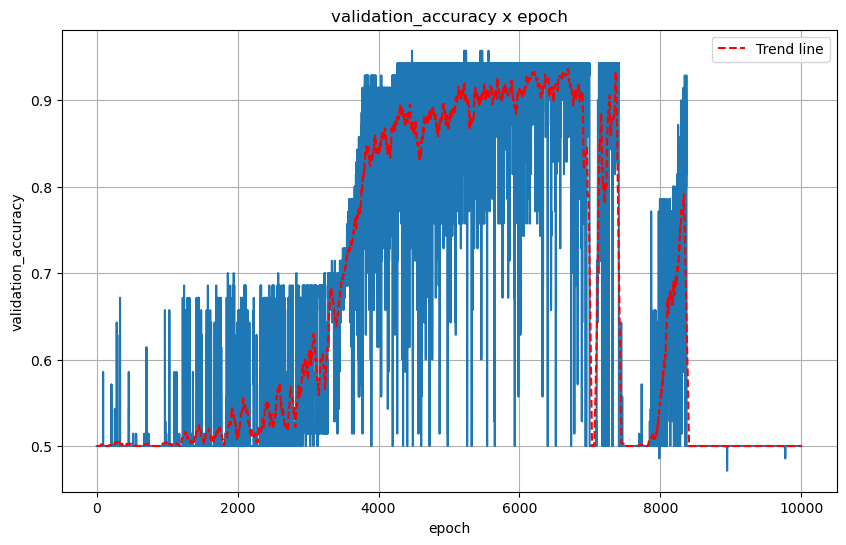

In [14]:
plot_learning_curve('./data/saves/logs/Bere_SH_L50_1.csv', kernel_len=71)